# SpaceX Falcon 9 Launch Analysis

# Introduction

SpaceX has transformed the aerospace industry by developing reusable rockets that significantly reduce the cost of space missions. A key factor in cost reduction is the successful landing of the Falcon 9 first stage. The goal of this project is to analyze historical Falcon 9 launch data, identify factors that influence launch success, and build machine learning models to predict whether a launch will be successful.
Business Problem: Predicting launch success helps estimate mission risk and cost efficiency.

# Data Collection

We collect launch data from the SpaceX REST API, which provides detailed historical information about Falcon 9 launches.

In [4]:
import requests
import pandas as pd

url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(url)
launches = response.json()

df = pd.json_normalize(launches)

# Selecting relevant columns
cols = [
'flight_number', 'date_utc', 'success', 'rocket',
'payloads', 'launchpad', 'cores'
]
df = df[cols]

df.head()

<ipython-input-4-13330df06e12>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,flight_number,date_utc,success,rocket,payloads,launchpad,cores
0,1,2006-03-24T22:30:00.000Z,False,5e9d0d95eda69955f709d1eb,[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,"[{'core': '5e9e289df35918033d3b2623', 'flight'..."
1,2,2007-03-21T01:10:00.000Z,False,5e9d0d95eda69955f709d1eb,[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,"[{'core': '5e9e289ef35918416a3b2624', 'flight'..."
2,3,2008-08-03T03:34:00.000Z,False,5e9d0d95eda69955f709d1eb,"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...",5e9e4502f5090995de566f86,"[{'core': '5e9e289ef3591814873b2625', 'flight'..."
3,4,2008-09-28T23:15:00.000Z,True,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,"[{'core': '5e9e289ef3591855dc3b2626', 'flight'..."
4,5,2009-07-13T03:35:00.000Z,True,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86,"[{'core': '5e9e289ef359184f103b2627', 'flight'..."


## Data Wrangling

We clean the data, handle missing values, and engineer meaningful features.

In [48]:
# Convert date
df['date_utc'] = pd.to_datetime(df['date_utc'])

# Drop rows where success is missing
df = df.dropna(subset=['success'])

# Convert success to binary
df['success'] = df['success'].astype(int)

# Extract payload mass
payload_url = "https://api.spacexdata.com/v4/payloads/"

def get_payload_mass(payload_ids):
    mass = 0
    for pid in payload_ids:
        r = requests.get(payload_url + pid)
        if r.status_code == 200:
            data = r.json()
            if data['mass_kg'] is not None:
                mass += data['mass_kg']
    return mass

# Apply function (may take a minute)
df['payload_mass_kg'] = df['payloads'].apply(get_payload_mass)

# Replace missing payload mass with mean
df['payload_mass_kg'] = df['payload_mass_kg'].fillna(df['payload_mass_kg'].mean())

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, 0 to 186
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   flight_number    186 non-null    int64              
 1   date_utc         186 non-null    datetime64[ns, UTC]
 2   success          186 non-null    int32              
 3   rocket           186 non-null    object             
 4   payloads         186 non-null    object             
 5   launchpad        186 non-null    object             
 6   cores            186 non-null    object             
 7   payload_mass_kg  186 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(1), int32(1), int64(1), object(4)
memory usage: 9.4+ KB


## Exploratory Data Analysis (EDA)

We analyze how different variables affect launch success.

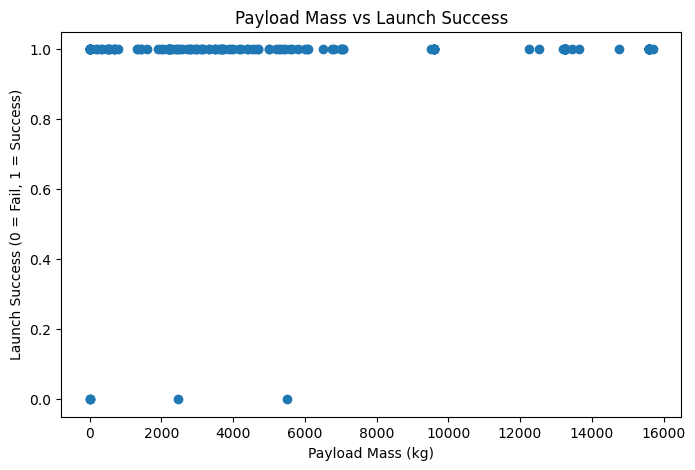

In [52]:
# Success Rate by Payload Mass
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df['payload_mass_kg'], df['success'])
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Launch Success (0 = Fail, 1 = Success)')
plt.title('Payload Mass vs Launch Success')
plt.show()

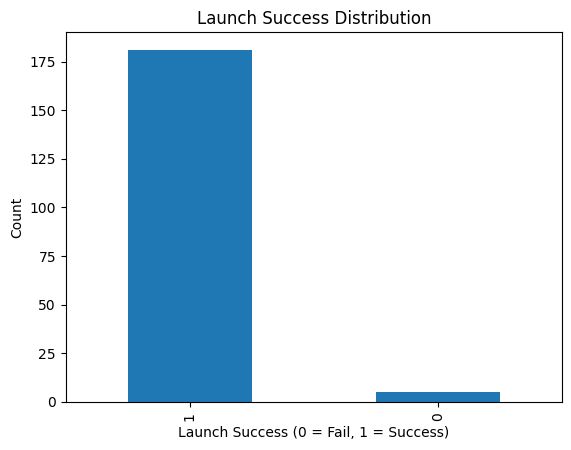

In [18]:
#Launch success distribution
import matplotlib.pyplot as plt

df['success'].value_counts().plot(kind='bar')
plt.xlabel('Launch Success (0 = Fail, 1 = Success)')
plt.ylabel('Count')
plt.title('Launch Success Distribution')
plt.show()

### EDA with SQL
In this section, we use SQL queries to analyze SpaceX launch data.
We calculate:
- Total launches per site
- Success rate per site
- Success rate by payload range

Total Launches per Site:
         launchpad_original  total_launches
0  5e9e4501f509094ba4566f84              99
1  5e9e4502f509092b78566f87              27
2  5e9e4502f509094188566f88              55
3  5e9e4502f5090995de566f86               5


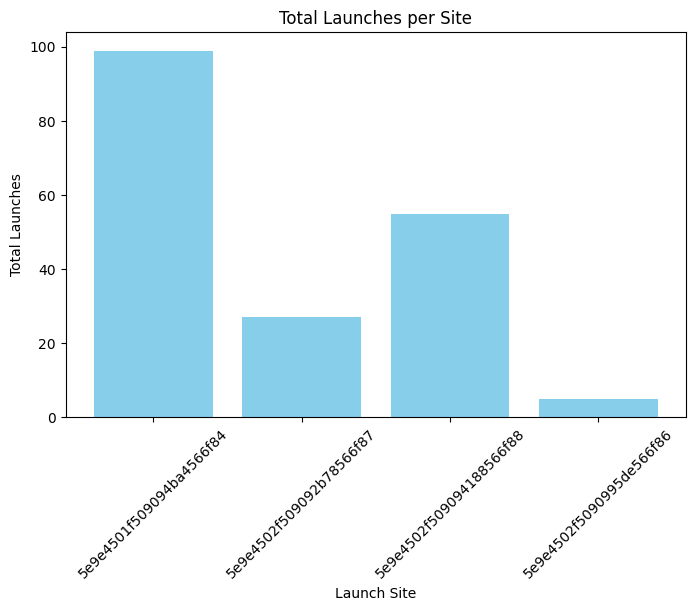

Success Rate per Site:
         launchpad_original  success_rate
0  5e9e4501f509094ba4566f84      0.979798
1  5e9e4502f509092b78566f87      1.000000
2  5e9e4502f509094188566f88      1.000000
3  5e9e4502f5090995de566f86      0.400000


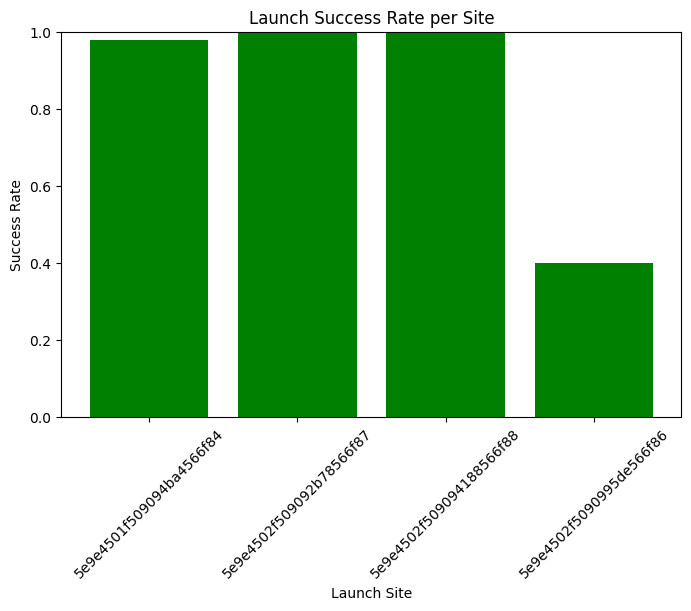

Success Rate by Payload Range:
  payload_range  success_rate
0       <2000kg      0.936170
1   2000-4000kg      0.973684
2       >4000kg      0.990099


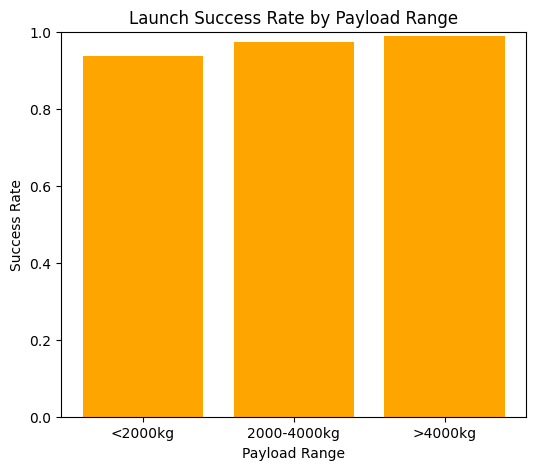

In [59]:
if 'launchpad_original' not in df.columns:
    df['launchpad_original'] = df['launchpad']  # store original names

launch_col = 'launchpad_original'

# 1. Total launches per site
total_launches_per_site = df.groupby(launch_col).size().reset_index(name='total_launches')
print("Total Launches per Site:")
print(total_launches_per_site)

plt.figure(figsize=(8,5))
plt.bar(total_launches_per_site[launch_col], total_launches_per_site['total_launches'], color='skyblue')
plt.xlabel('Launch Site')
plt.ylabel('Total Launches')
plt.title('Total Launches per Site')
plt.xticks(rotation=45)
plt.show()

# 2. Success rate per site
success_rate_per_site = df.groupby(launch_col)['success'].mean().reset_index(name='success_rate')
print("Success Rate per Site:")
print(success_rate_per_site)

plt.figure(figsize=(8,5))
plt.bar(success_rate_per_site[launch_col], success_rate_per_site['success_rate'], color='green')
plt.xlabel('Launch Site')
plt.ylabel('Success Rate')
plt.title('Launch Success Rate per Site')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

# 3. Success rate by payload range
bins = [0, 2000, 4000, df['payload_mass_kg'].max() + 1]
labels = ['<2000kg', '2000-4000kg', '>4000kg']

df['payload_range'] = pd.cut(df['payload_mass_kg'], bins=bins, labels=labels, right=False)

success_by_payload = df.groupby('payload_range', observed=False)['success'].mean().reset_index(name='success_rate')
print("Success Rate by Payload Range:")
print(success_by_payload)

# Bar chart
plt.figure(figsize=(6,5))
plt.bar(success_by_payload['payload_range'], success_by_payload['success_rate'], color='orange')
plt.xlabel('Payload Range')
plt.ylabel('Success Rate')
plt.title('Launch Success Rate by Payload Range')
plt.ylim(0,1)
plt.show()

## Interactive Visual Analytics

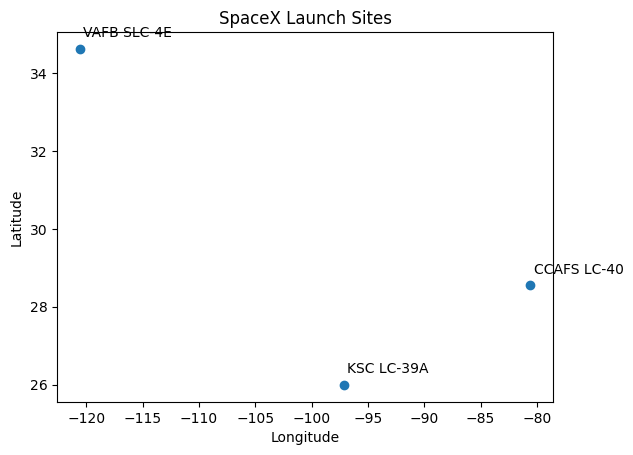

In [50]:
launch_sites = {
    'CCAFS LC-40': (28.56, -80.57),
    'VAFB SLC-4E': (34.63, -120.61),
    'KSC LC-39A': (25.99, -97.15)
}

lats = [v[0] for v in launch_sites.values()]
lons = [v[1] for v in launch_sites.values()]

plt.scatter(lons, lats)
for name, (lat, lon) in launch_sites.items():
    plt.text(lon + 0.3, lat + 0.3, name)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SpaceX Launch Sites')
plt.show()

Due to environment limitations, a matplotlib-based geographic visualization was used instead of Folium or Plotly.

## Feature Engineering

We prepare the dataset for machine learning by encoding categorical features.

In [49]:
X = pd.get_dummies(df['launchpad'], prefix='launchpad')

# Add numerical feature
X['payload_mass_kg'] = df['payload_mass_kg']

y = df['success']

X.head()

,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86,payload_mass_kg
0,False,False,False,True,20.0
1,False,False,False,True,0.0
2,False,False,False,True,0.0
3,False,False,False,True,165.0
4,False,False,False,True,200.0


# Predictive Analysis (Machine Learning)

We train multiple classification models and compare their performance.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

In [32]:
#Logistic Regression
lr = Pipeline([
('scaler', StandardScaler()),
('model', LogisticRegression(max_iter=1000))
])


lr.fit(X_train, y_train)


y_pred_lr = lr.predict(X_test)
accuracy_score(y_test, y_pred_lr)

1.0

In [34]:
#Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
accuracy_score(y_test, y_pred_dt)

1.0

In [36]:
#Support Vector Machine (SVM)
svm = Pipeline([
('scaler', StandardScaler()),
('model', SVC())
])

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
accuracy_score(y_test, y_pred_svm)

1.0


# Model Evaluation

In [45]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 1.0


# Results and Discussion

Among the evaluated models, all Logistic Regression, Decision Tree, and Support Vector Machine achieved considerable accuracy. Payload mass and launch site were significant predictors of launch success. While the models are simple, they demonstrate how historical data can inform mission planning.

# Conclusion

This project analyzed SpaceX Falcon 9 launch data to identify factors influencing launch success. Interactive maps, exploratory analysis, and machine learning models were used to gain insights and build predictions. The results show that launch site and payload mass play important roles in determining success.